<a href="https://colab.research.google.com/github/ADebor/adebor.github.io/blob/master/notebooks/syst0002_nb2_2324.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYST0002 - Notebook 2

## Convolution

---

Ce deuxième notebook Python est destiné à approfondir et à présenter de manière plus visuelle et interactive les concepts abordés aux séances de travaux dirigés portant sur la convolution de signaux. Il vise également à vous présenter l'outil notebook et à vous donner une base de code pour pouvoir expérimenter par vous-mêmes. Ce notebook est un support éducatif supplémentaires aux exercices et nous espérons qu'il vous aidera à mieux appréhender la matière et les concepts abordés. Pour plus d'information à propos des notebooks dans Google Colab, visitez [ceci](https://ledatascientist.com/google-colab-le-guide-ultime/).

---


## 0. Installation des packages Python nécessaires et importation

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
from PIL import Image
import requests

## 1. Convolution de signaux 1D (traitement de signaux temporels)
### Rappels
Considérons le signal $s(t)$ défini par
$$
s(t) = \begin{cases}
sin(t) & \text{si } \; t \in [-\pi; \pi]\\
0 & \text{sinon,}
\end{cases}
$$
et le signal $k(t)$ défini par
$$
k(t) = \begin{cases}
e^{-at} & \text{si } \; t>0\\
0 & \text{sinon,}
\end{cases}
$$
avec $a>0$.

Visualisons ces signaux pour $a=2$ :

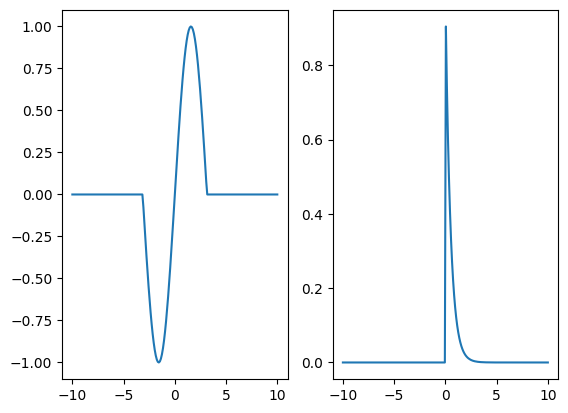

In [38]:
a=2

# générons nos signaux
def s(t):
  return np.sin(t) if (t >= -np.pi and t <= np.pi) else 0

def k(t):
  return np.exp(-a * t) if t > 0 else 0

# time discretization
dt = 0.1
t_min = -10
t_max = 10
ts = np.linspace(t_min, t_max, int((t_max-t_min) / dt))

s_signal = np.asarray([s(t) for t in ts])
k_signal = np.asarray([k(t) for t in ts])
ax = plt.subplot(1, 2, 1)
ax.plot(ts, s_signal)
ax = plt.subplot(1, 2, 2)
ax.plot(ts, k_signal)

Si nous calculons le produit de convolution entre ces deux signaux de manière graphique ou analytique, on obtient la forme par morceaux suivante:
$$
c(t) = s(t) * k(t) = k(t) * s(t) = \begin{cases}
0 & \text{si } \; t < -\pi \\
\frac{1}{1+a^2}(a \sin(t) - \cos(t) - e^{-a(t+\pi)}) & \text{si } \; t \in [-\pi; \pi] \\
\frac{1}{1+a^2}(e^{-a(t-\pi)} - e^{-a(t+\pi)}) & \text{si } \; t > \pi.
\end{cases}
$$

Il vous est **fortement** conseillé d'établir ce résultat par vous-même.

Traçons maintenant ce produit de convolution à partir du résultat analytique obtenu :

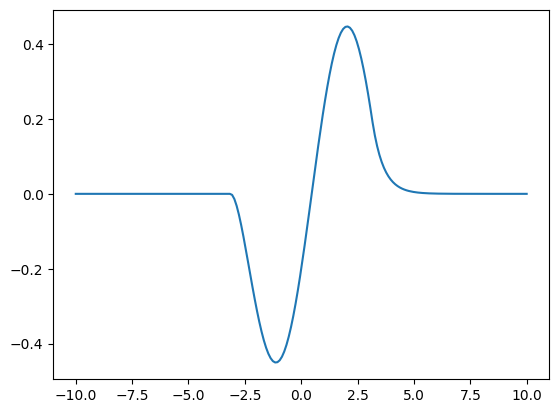

In [39]:
def c(t):
  if t < -np.pi:
    return 0
  elif t > np.pi:
    return 1/(1+a**2) * (np.exp(-a * (t-np.pi)) - np.exp(-a * (t+np.pi)))
  else:
    return 1/(1+a**2) * (a * np.sin(t) - np.cos(t) - np.exp(-a*(t+np.pi)))

res_hand = [c(t) for t in ts]
plt.plot(ts, res_hand)

Calculons à présent en utilisant la fonction [*convolve*](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) de NumPy, qui calcule le produit de convolution discret entre deux séquences discrètes. Cette fonction accepte un argument "*mode*", qui peut prendre 3 valeurs : *full* (par défaut), *same* et *valid*. Nous vous invitons à aller lire en quoi la valeur de cet argument influence le résultat du produit de convolution. De manière générale, prenez l'habitude de vous renseigner sur le principe et les arguments disponibles pour les fonctions d'un package.

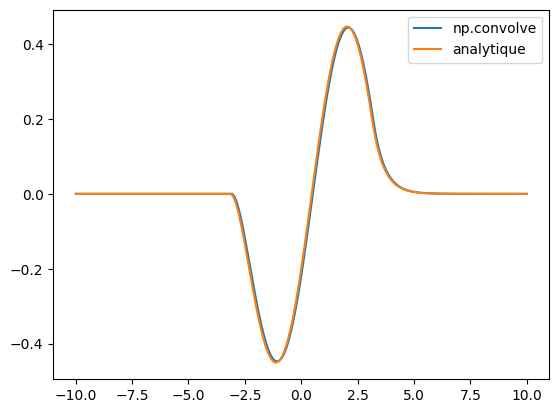

In [40]:
res_np = dt * np.convolve(s_signal, k_signal, 'same') # le facteur dt vient de la manière dont est implémentée la fonction convolve de NumPy

plt.plot(ts, res_np, label='np.convolve')
plt.plot(ts, res_hand, label='analytique')
plt.legend()

### Convolution 1D et *kernels*
Une méthode numérique ne peut travailler avec des signaux continus. Il existe donc des outils pour approximer le produit de convolution continu vu au cours pour des signaux discrets. Sans entrer dans les détails, nous allons ici explorer le concept de *kernel*. **Ce type de convolution discrète n'est pas matière du cours, et est présenté uniquement dans le but de vous donner une meilleure intuition quant au concept de convolution**.

Commençons par générer artificiellement un signal sinusoïdal bruité $s_{noisy}$.

In [41]:
p = 200 # nombre de points
s = np.sin(np.linspace(0, 10*np.pi, p))  # signal "idéal"
n = np.random.normal(0., .3, p) # bruit additif (gaussien)
s_noisy = s + n  # signal bruité

Traçons les signaux générés.

Text(0.5, 0, 't')

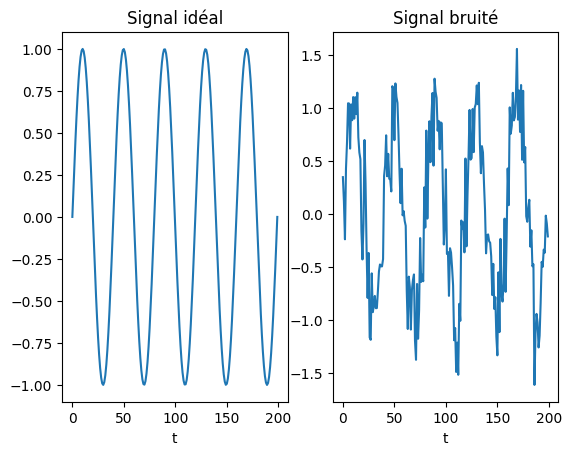

In [42]:
ax = plt.subplot(1, 2, 1)
ax.set_title("Signal idéal")
plt.plot(s)
plt.xlabel('t')

ax = plt.subplot(1, 2, 2)
ax.set_title("Signal bruité")
plt.plot(s_noisy)
plt.xlabel('t')

Définissons maintenant un vecteur $k$ (que nous appellerons *kernel*) qui va réaliser une moyenne mobile (*moving average* ou *running average* en anglais) de taille 5. Autrement dit, ce vecteur va lisser le signal bruité en asssignant à chacun des points de ce dernier une nouvelle valeur, égale à la moyenne arithmétique (d'où le facteur 1/5) des 4 points l'entourant (2 à gauche, 2 à droite) et de lui-même. L'application de ce *kernel* au signal bruité va se faire en convoluant le *kernel* et le signal bruité. Le *kernel* représente donc une approximation discrète d'une fonction continue moyennant le signal avec lequel elle est convoluée.

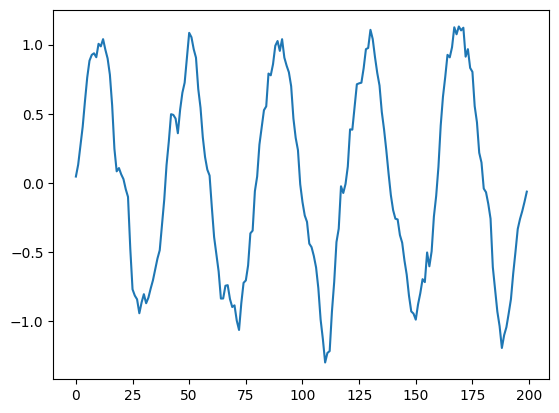

In [43]:
k = 1/5 * np.array([1, 1, 1, 1, 1]) # kernel
s_smooth = np.convolve(s_noisy, k, 'same')  # signal convolué

plt.plot(s_smooth)

On observe que l'application du vecteur $k$ sur le signal a en effet lissé celui-ci. On peut considérer des moyennes sur plus de points, et observer un lissage de plus en plus agressif.

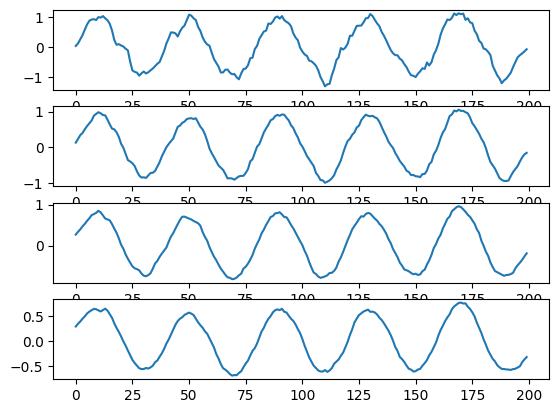

In [44]:
sizes = [5, 10, 15, 20]
for i, size in enumerate(sizes):
  ax = plt.subplot(len(sizes), 1, i+1)
  k = 1/size * np.ones(size) # kernel
  s_smooth = np.convolve(s_noisy, k, 'same')  # signal convolué

  plt.plot(s_smooth)

On peut également considérer un *kernel* différent, en fonction de l'effet recherché. Ainsi, on peut décider de donner plus de poids à la valeur centrale de la moyenne.

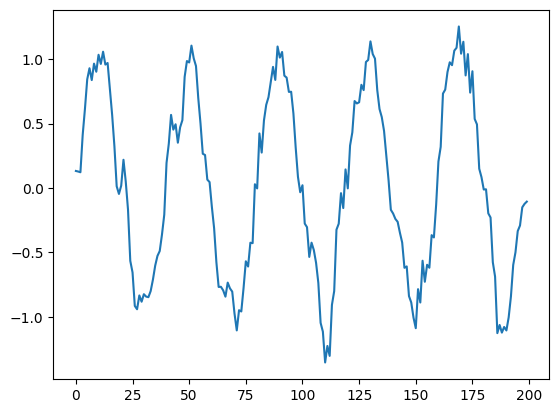

In [45]:
k = 1/7 * np.array([1, 1, 3, 1, 1]) # kernel
s_smooth = np.convolve(s_noisy, k, 'same')  # signal convolué

plt.plot(s_smooth)

Une autre manière de filtrer le signal est d'utiliser un filtre passe-bas. Un tel filtre permet d'atténuer les composantes fréquentielles du signal qui sont au dessus d'une certaine bande de fréquences. Dans le domaine fréquentiel, un tel filtre est idéalement un "rectangle", centré en 0, tel que les fréquences situées au dessus de ses bornes sont atténuées lorsque ce filtre est appliqué. Dans le domaine temporel, un tel filtre correspond, nous l'avons vu, à un sinus cardinal centré en 0.

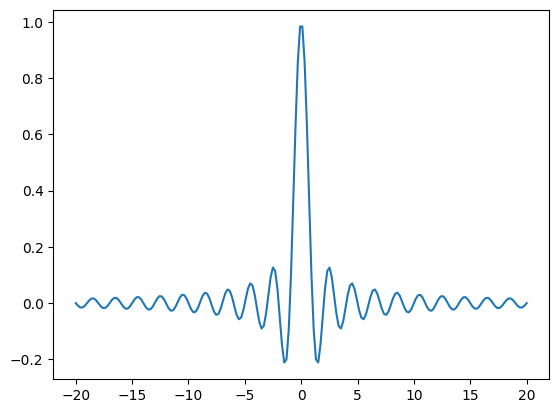

In [46]:
x = np.linspace(-20, 20, 200)
y = np.sinc(x)
plt.plot(x, y)

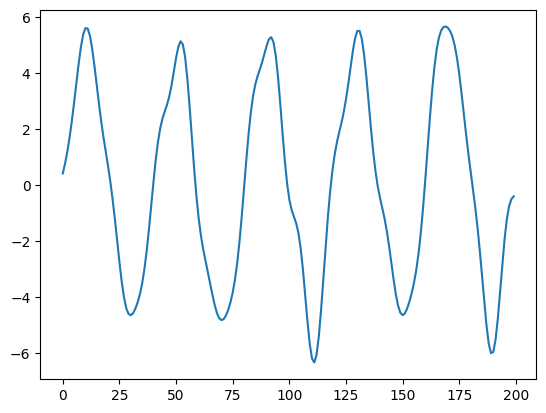

In [47]:
k = y # kernel
s_smooth = np.convolve(s_noisy, k, 'same')  # signal convolué

plt.plot(s_smooth)

## 2. Convolution de signaux 2D (traitement d'image)

### Principe de la convolution 2D et filtrage
Jusqu'à présent, nous avons travaillé avec des signaux temporels (1D) uniquement. Il est également possible d'appliquer le concept de convolution à des signaux spatiaux (2D), comme des images. Le principe est globalement le même, à ceci près que l'on va désormais considérer des signaux ou des kernels à 2 dimensions. Les concepts présentés ici utilisent à nouveau la notion de *kernel*, définis cette fois comme des matrices approximant une fonction 2D. Une illustration de l'application d'un tel kernel à une image (*input*) est donnée ci-dessous (Source : [Prakhar Ganesh](https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37)).

![Url](https://miro.medium.com/v2/resize:fit:640/format:webp/1*Eai425FYQQSNOaahTXqtgg.gif)

### Applications

La convolution est utilisée en traitement d'image et en vision par ordinateur pour *filtrer* les images, et ainsi obtenir une image plus ou moins floue par exemple, ou encore pour détecter les contours. Ce type d'opération peut être requis dans une application traîtant des images ou des vidéos comme par exemple le contrôle qualité automatisé sur une chaîne de production.

Les concepts de *kernel* et de convolution sont également les briques de base des systèmes modernes de traîtement d'image basés sur le *deep learning* ou apprentissage profond (technique à qui l'on doit la révolution de ce que l'on appelle communément l'intelligence artificielle). En particulier, les réseaux neuronaux convolutionnels sont à la base de la révolution du traîtement de l'image par ces techniques.

Ci-après, nous allons explorer des exemples de *kernels* 2D et observer leurs effets sur une image de référence.

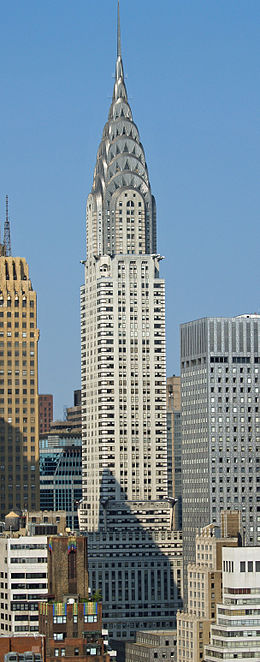

In [49]:
# récupérons l'image depuis Wikipédia
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Chrysler_Building_by_David_Shankbone.jpg/260px-Chrysler_Building_by_David_Shankbone.jpg'
img = Image.open(requests.get(url, stream=True).raw)
img

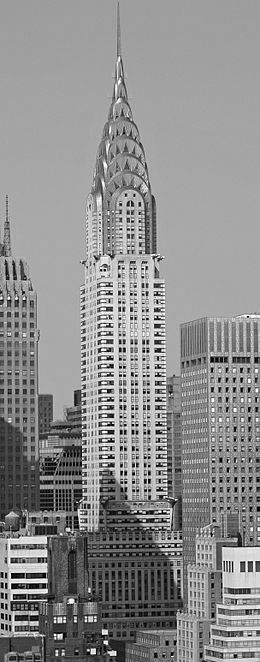

In [50]:
# transformons l'image RGB en niveaux de gris par facilité
img = cv.cvtColor(np.array(img), cv.COLOR_BGR2GRAY)
cv2_imshow(img)

Appliquons un *box blur*, c'est-à-dire un floutage uniforme. Le kernel correspondant est représenté ci-dessous et l'application de ce kernel à un pixel correspond à une moyenne entre les valeurs des pixels voisins de ce pixel.

$$\frac{1}{9}\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1 \\
1 & 1 & 1
\end{pmatrix}$$

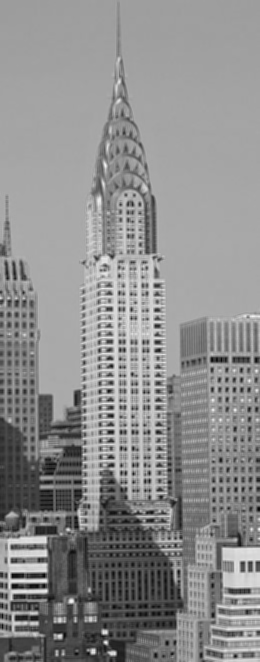

In [52]:
# box blur (floutage uniforme)
k = np.ones((3, 3), np.float32) / 9
img_blur = cv.filter2D(src=img, ddepth=-1, kernel=k)  # convolution

cv2_imshow(img_blur)

Réalisons maintenant une détection de crêtes basique, en utilisant le *kernel* suivant :
$$\begin{pmatrix}
-1 & -1 & -1\\
-1 & 8 & -1 \\
-1 & -1 & -1
\end{pmatrix}$$

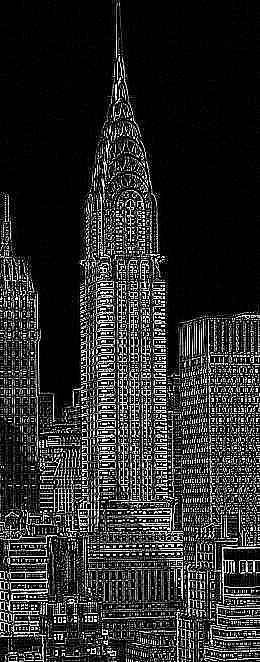

In [53]:
# edge/ridge detection (détection de crêtes)
k = -np.ones((3, 3))
k[1][1] = 8
img_edge = cv.filter2D(src=img, ddepth=-1, kernel=k)  # convolution

cv2_imshow(img_edge)

Enfin, implémentons une technique un peu plus avancée de détection de crêtes. Cette technique utilise deux *kernels* : un approxime le gradient vertical et l'autre le gradient horizontal des valeurs de niveau de gris dans l'image :


$$
G_y = \begin{pmatrix}
+1 & +2 & +1\\
0 & 0 & 0 \\
-1 & -2 & -1
\end{pmatrix}
,\; G_x =\begin{pmatrix}
-1 & 0 & +1\\
-2 & 0 & +2 \\
-1 & 0 & +1
\end{pmatrix}.$$

En convoluant ces deux kernels de manière séparée avec l'image de base, on procède ainsi à une détection de crêtes horizontales et verticales, respectivement. En combinant les deux, on procède donc à une détection de crêtes dans les deux dimensions.

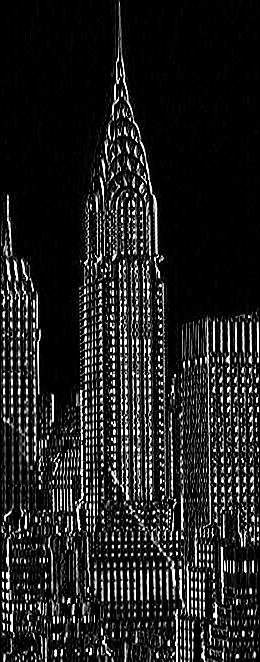

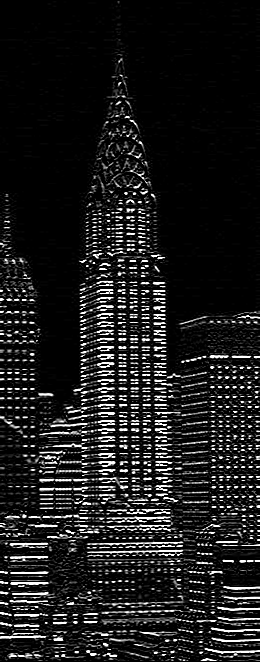

In [56]:
# Sobel gradient filters (gradients horizontaux et verticaux)

g_x_k = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
g_y_k = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

g_x = cv.filter2D(src=img, ddepth=-1, kernel=g_x_k)
g_y = cv.filter2D(src=img, ddepth=-1, kernel=g_y_k)

cv2_imshow(g_x)
cv2_imshow(g_y)

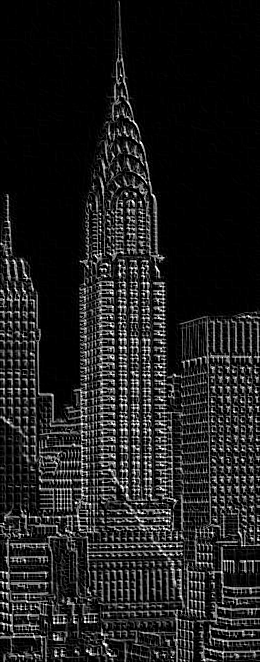

In [57]:
# Sobel edge detection (combinaison des gradients pour la détection d'arêtes)
g = 0.5*np.abs(g_x) + 0.5*np.abs(g_y)
cv2_imshow(g)